# Firewood math and metrics



We inherited a large pile of firewood for a wood burning stove. We've never had a wood burning stove. People who actually know something about, or sell, firewood for such devices talk about *cords* and *face cords* of firewood. Time to learn something about firewood metrics.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Cords and face cords

A [cord of firewood](https://woodheat.org/cord-wood.html) is about $4 \text{ft} \times 4 \text{ft} \times 8 \text{ft}$, or $128 \text{ft}^3$ in volume. Typically, a log for a wood burning stove is approximately $16 \text{in}$. So, you can slice a full cord into three *face cords*, each being $4 \text{ft} \times 1 \frac {1}{3} \text{ft} \times 8 \text{ft}$. Of course, that's not all wood because there is a bunch of air in the stack. But, I'm not so interested in weight, I'm interested in number of logs and how long our stack of wood will last.


## How much wood do we have?

It appears that when our stack of logs was full, it was two cords (~16 feet long).

Obviously, the number of logs in a face cord is dependent on the diameter of the logs. I did a rough count and got about 20 logs wide by 10 logs high for each face cord.

In [41]:
pile_height_logs = 10
pile_width_logs = 20
logs_per_facecord = pile_height_logs * pile_width_logs
logs_per_cord = 3 * logs_per_facecord
print("Logs per face cord: {}".format(logs_per_facecord))
print("Logs per cord: {}".format(logs_per_cord))

Logs per face cord: 200
Logs per cord: 600


In [6]:
num_facecords = 6
tot_logs = logs_per_facecord * num_facecords
print("Total logs in full pile: {}".format(tot_logs))

Total logs in full pile: 1200


We've used some wood - maybe about 75% of a face cord.

In [7]:
num_facecords_used = 0.75
tot_logs_remaining = logs_per_facecord * (num_facecords - num_facecords_used)
print("Total logs left in partial pile: {}".format(int(tot_logs_remaining)))

Total logs left in partial pile: 1050


## How much wood do we use?

On a winter day in which we keep the stove going from morning until night, we use approximately 12-14 logs.

In [11]:
logs_per_day = 13

The largest source of uncertainty is the number of *equivalent burning days* (EBD) in which we use the stove. Some days we might just burn a few logs in the evening. Here's an estimate of EBD by month:

In [12]:
ebd_month_mean = [5, 10, 5, 5, 2, 1, 2, 1, 3, 5, 5, 10]

In [13]:
logs_per_month_mean = [logs_per_day * ebd for ebd in ebd_month_mean]
print(logs_per_month_mean)
logs_per_year = sum(logs_per_month_mean)
print("Total logs burned per year: {}".format(logs_per_year))

[65, 130, 65, 65, 26, 13, 26, 13, 39, 65, 65, 130]
Total logs burned per year: 702


## How long would a cord last?

In [14]:
print("One cord lasts ~ {:.2f} years.".format(logs_per_cord / logs_per_year))

One cord lasts ~ 0.85 years.


In [15]:
print("Two cords lasts ~ {:.2f} years.".format(2 * logs_per_cord / logs_per_year))

Two cords lasts ~ 1.71 years.


## Simulating firewood use

The largest component of uncertainty is our monthly usage. Let's assume that log usage can be approximated by a normal distribution with monthly means specified by `logs_per_month_mean` and monthly standard deviations equal to the square root of the means.

In [16]:
logs_per_month_sd = [math.sqrt(mean) for mean in logs_per_month_mean] 

Let's have the simulation clock tick in months and we'll simulate until we run out of logs. We'll record the month in which that happens.

In [17]:
def logsim(numlogs, logs_per_month_mean, logs_per_month_sd):
    period = 0
    month = period % 12

    while numlogs > 0:
        logs_used = round(np.random.normal(logs_per_month_mean[month], logs_per_month_sd[month]))
        numlogs -= logs_used
        period += 1
        month = period % 12

    return period
    

In [20]:
nsim = 10000
sim = 0
stockout_period = []
num_logs_current = tot_logs_remaining

while sim < nsim:
    so_prd = logsim(num_logs_current, logs_per_month_mean, logs_per_month_sd)
    stockout_period.append(so_prd)
    sim += 1
    
print(stockout_period[:100])
    

[18, 19, 19, 16, 17, 16, 16, 16, 17, 16, 19, 20, 20, 16, 20, 18, 16, 16, 18, 18, 19, 18, 19, 19, 18, 16, 21, 19, 16, 20, 19, 16, 16, 20, 16, 17, 21, 16, 16, 16, 20, 16, 19, 19, 16, 17, 19, 17, 19, 21, 19, 18, 19, 17, 16, 18, 19, 17, 19, 17, 19, 17, 19, 18, 19, 16, 19, 17, 19, 18, 21, 19, 16, 19, 16, 17, 16, 21, 17, 17, 19, 19, 18, 18, 19, 20, 16, 20, 19, 17, 19, 18, 17, 17, 16, 17, 17, 19, 17, 18]


Let's compute summary stats and create a histogram.

In [27]:
stockout_df = pd.DataFrame({'stockout_period': stockout_period})
stockout_stats = stockout_df.describe()
stockout_stats

,stockout_period
count,10000.000000
mean,17.659300
std,1.426474
min,15.000000
25%,17.000000
50%,17.000000
75%,19.000000
max,22.000000


In [33]:
minbin = int(stockout_stats.loc['min'])-1
maxbin = int(stockout_stats.loc['max'])+1
bins = np.linspace(minbin, maxbin, maxbin - minbin + 1)
bins

array([14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4df3dcd30>]],
      dtype=object)

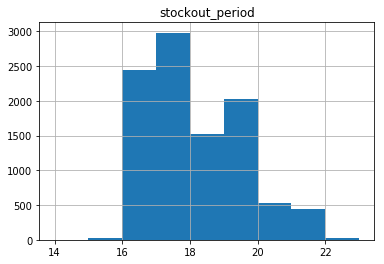

In [34]:

so_df.hist(bins=bins)

In [38]:
start_period = pd.Period('2019-01-01',freq='M')
median_stockout = start_period + int(stockout_stats.loc['50%'])
q1_stockout = start_period + int(stockout_stats.loc['25%'])
q3_stockout = start_period + int(stockout_stats.loc['75%'])


In [40]:
print("The median stockout period is: {}".format(median_stockout))
print("The IQR for the stockout period is: {} - {}".format(q1_stockout, q3_stockout))

The median stockout period is: 2020-06
The IQR for the stockout period is: 2020-06 - 2020-08


Looks like the log pile will be gone in summer of 2020.